In [200]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.utils import survival_table_from_events

%matplotlib inline
warnings.filterwarnings("ignore")
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 9)

Populating the interactive namespace from numpy and matplotlib


In [201]:
DATA_INTER_PATH = os.path.join('..', 'data', 'interim')
DATA_PROCE_PATH = os.path.join('..', 'data', 'processed')
IMG_PATH = os.path.join('..','reports', 'figures')
DATA_INTER_NAME = 'general.csv'
DATA_INTER_NAME_2 = 'general_2.csv'
DATA_PROCE_NAME = 'processed.csv'

## Survival Analysis

In [202]:
def survival_probability(value):

    array = np.asarray(survtable["at_risk"].index)
    idx = (np.abs(array - value)).argmin()
    
    temp = survtable.reset_index()
    proba = temp[temp['event_at'] == array[idx]].at_risk.values[0]*100
    
    return print("A probabilidade de sobrevivência do cliente após", array[idx], "dias é", round(proba, 2),"%") 

In [203]:
df = pd.read_csv(os.path.join(DATA_PROCE_PATH, DATA_PROCE_NAME))
df.head(1)

,customer_code,group_code,segment_code,total_price,item_total_price,discount,last_purchase_date,qnt_days,is_churn
0,0,0,0,74215.11,84322.67,1,2018-06-08 00:00:00+00:00,54,0.0


In [204]:
time = df["qnt_days"]
event = df["is_churn"]

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed=event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 818 total observations, 737 right-censored observations>

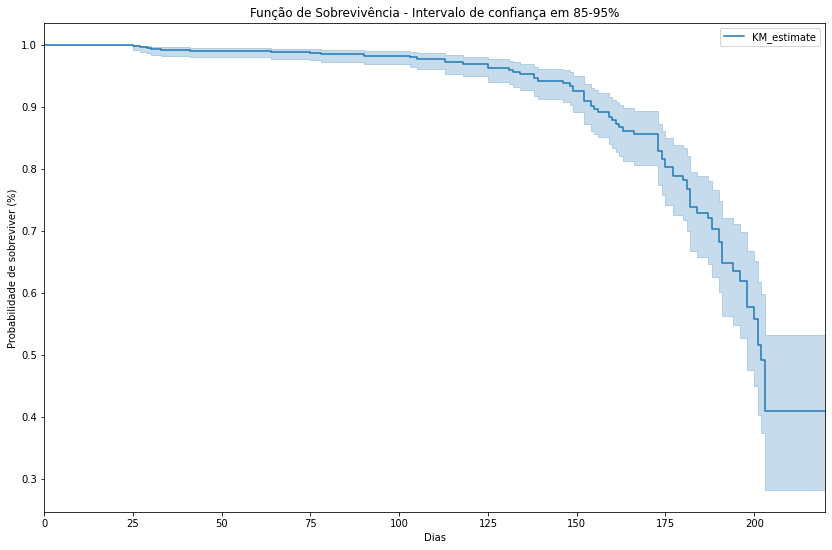

In [205]:
kmf.plot()
plt.xlim(0, 220)
plt.title('Função de Sobrevivência - Intervalo de confiança em 85-95%');
plt.ylabel('Probabilidade de sobreviver (%)')
plt.xlabel('Dias')
plt.savefig(os.path.join(IMG_PATH,'km-general.png'), format='png')
plt.show()

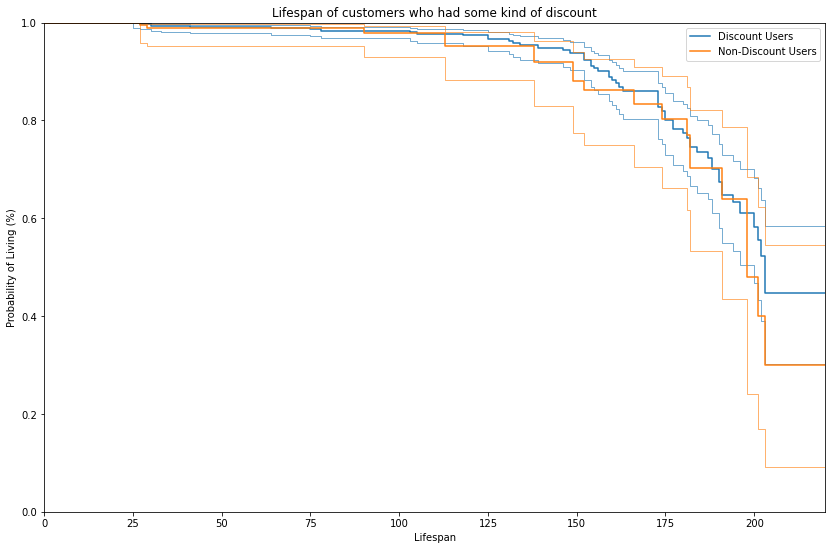

In [206]:
ax = plt.subplot(111)

discount = (df["discount"] == 1)
kmf.fit(time[discount], event_observed=event[discount], label="Discount Users")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(time[~discount], event_observed=event[~discount], label="Non-Discount Users")
kmf.plot(ax=ax, ci_force_lines=True)
plt.ylim(0,1)
plt.xlim(0, 220)
plt.title("Lifespan of customers who had some kind of discount")
plt.ylabel('Probability of Living (%)')
plt.xlabel('Lifespan')
plt.savefig(os.path.join(IMG_PATH,'km-discount.png'), format='png')
plt.show()

In [207]:
groups = sorted(df.group_code.unique())
segments = sorted(df.segment_code.unique())

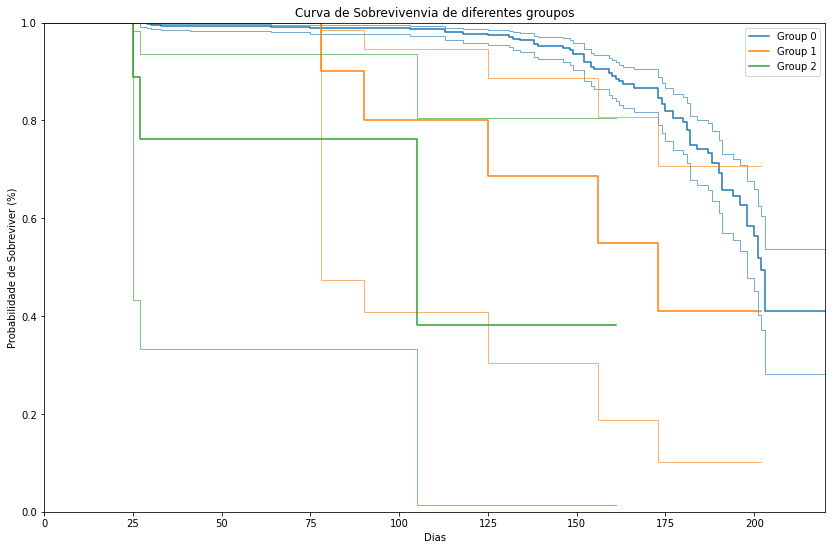

In [208]:
ax = plt.subplot(111)

group_0 = (df["group_code"] == groups[0])
group_1 = (df["group_code"] == groups[1])
group_2 = (df["group_code"] == groups[2])

kmf.fit(time[group_0], event_observed=event[group_0], label="Group 0")
kmf.plot(ax=ax, ci_force_lines=True)

kmf.fit(time[group_1], event_observed=event[group_1], label="Group 1")
kmf.plot(ax=ax, ci_force_lines=True)

kmf.fit(time[group_2], event_observed=event[group_2], label="Group 2")
kmf.plot(ax=ax, ci_force_lines=True)

plt.xlim(0, 220)
plt.ylim(0,1)
plt.title("Curva de Sobrevivenvia de diferentes groupos")
plt.ylabel('Probabilidade de Sobreviver (%)')
plt.xlabel('Dias')
plt.savefig(os.path.join(IMG_PATH,'km-group.png'), format='png')
plt.show()

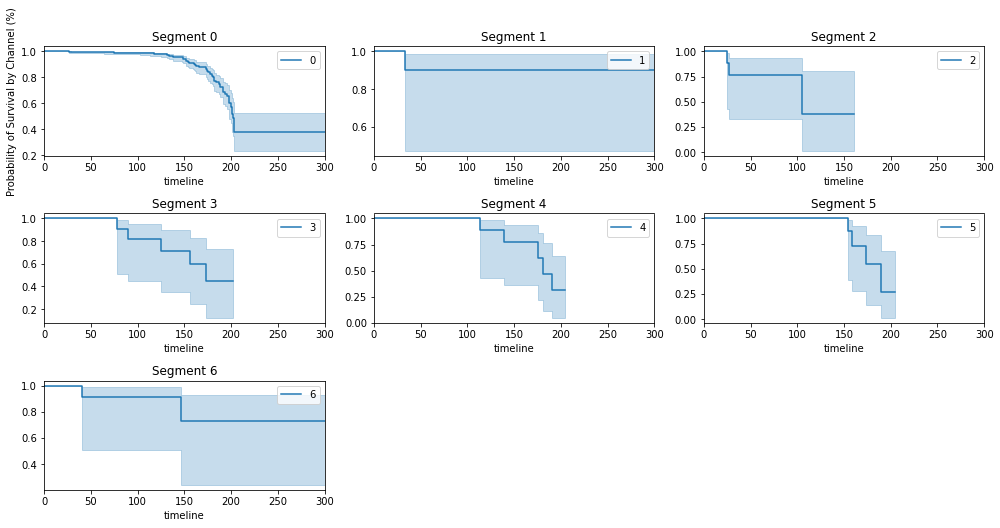

In [209]:
for i, segment_type in enumerate(segments):
    ax = plt.subplot(4,3,i+1)
    ix = df['segment_code'] == segment_type
    kmf.fit(time[ix], event[ix], label=segment_type )
    kmf.plot(ax=ax, legend=True)
    plt.title(f'Segment {segment_type}')
    plt.xlim(0,300)
    if i==0:
        plt.ylabel('Probability of Survival by Channel (%)')
        
plt.savefig(os.path.join(IMG_PATH,'km-segment.png'), format='png')
plt.tight_layout()

In [210]:
time = df["qnt_days"]
event = df["is_churn"]

lifetable = survival_table_from_events(time, event)

In [211]:
survivaltable = lifetable.at_risk/np.amax(lifetable.entrance)

In [212]:
survtable = pd.DataFrame(survivaltable)

In [213]:
survival_probability(50)

A probabilidade de sobrevivência do cliente após 50.0 dias é 79.71 %


## Modeling

## Considerações

1. Há um decaimento quase que exponencial depois do dia 150;
2. Depois do dia número 200, a probabilidade de sobrevivência de um cliente é de aproximadamente de 50%. Em outras palavras: depois de 200 dias, métade dos clientes dariam **churn**;
3. Clientes com e sem desconto tem comportamento semalhantes quanto a sobrevivencia;
4. O grupo 2 mostra maior probabilidade em um intervalo de tempo pequeno de dar churn;


Obs: A análise realizada para grupos e segmentos possuem um intervalo de confiança alto devido a faltas de dados para esses grupos.